In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
import warnings
import pickle

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [73]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
#from category_encoders.binary import BinaryEncoder

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error


In [28]:
# split datetime column into date and time
def split_datetime_column(df, date):
    df['time'] = df[date].str[10:]
    df['date'] = df[date].str[:10]
    df.drop(columns=['Timestamp'], inplace = True, axis=1)
    return df

#Convert Time to Sec
def time_to_secs(df):
  # Extract hours, minutes, and seconds using vectorized operations
  time_parts = df['time'].str[1:-1].str.split(':', expand=True).astype(int)
  hours, minutes, seconds = time_parts[0], time_parts[1], time_parts[2]
  df.drop(columns=['time'], inplace = True, axis=1)

  # Convert time to total seconds since midnight
  df['total_secs'] = hours * 3600 + minutes * 60 + seconds

# create a function to check for missing extracted dates
def get_missing_dates(df):
  col = df.index
  missing_dates = (pd.date_range(

      start=col.min(), #start date
      end=col.max())   #end_date
      .difference(col))
  print(f"we have {len(missing_dates)} dates missing out of {len(col)}")
  print(f"start: {col.min()}, end: {col.max()}")
  return missing_dates

# Fill missing values
def fill_missing_dates(df):
  missing_dates = (pd.DataFrame(
      pd.date_range(
        start=df.index.min(), end=df.index.max())
        .difference(df.index)
  , columns=['date']))

#add missing df dates
  df = pd.concat([df, missing_dates], ignore_index=True)

  #filling missing df values
  cols = df.columns
  for col in cols:
    df[col] = df[col].ffill().bfill()
  return df



### Load Source Data

In [3]:
train = pd.read_csv("../data/Train.csv")
test = pd.read_csv("../data/Test.csv")
weather = pd.read_csv("../data/Weather.csv")

df_train = train.copy()
df_test = test.copy()
df_weather = weather.copy()

In [4]:
print("Train Shapre:", df_train.shape)
print("Test Shapre:", df_test.shape)
print("Weather Shapre:", df_weather.shape)

Train Shapre: (83924, 8)
Test Shapre: (35625, 7)
Weather Shapre: (61, 10)


In [5]:
df_train.head()

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
0,000FLWA8,2019-12-04T20:01:50Z,3.258,36.777,3.003,36.718,39627,2784
1,000RGOAM,2019-12-10T22:37:09Z,3.087,36.707,3.081,36.727,3918,576
2,001QSGIH,2019-11-23T20:36:10Z,3.144,36.739,3.088,36.742,7265,526
3,002ACV6R,2019-12-01T05:43:21Z,3.239,36.784,3.054,36.763,23350,3130
4,0039Y7A8,2019-12-17T20:30:20Z,2.912,36.707,3.207,36.698,36613,2138


In [6]:
df_test.head()

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
0,000V4BQX,2019-12-21T05:52:37Z,2.981,36.688,2.978,36.754,17549
1,003WBC5J,2019-12-25T21:38:53Z,3.032,36.769,3.074,36.751,7532
2,004O4X3A,2019-12-29T21:30:29Z,3.035,36.711,3.010,36.758,10194
3,006CEI5B,2019-12-31T22:51:57Z,2.902,36.738,3.208,36.698,32768
4,009G0M2T,2019-12-28T21:47:22Z,2.860,36.692,2.828,36.696,4513


In [7]:
df_weather.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


In [8]:
# Drop Id columns from Train and Test datasets
df_train.drop(columns=['ID'], inplace = True, axis=1)
df_test.drop(columns=['ID'], inplace = True, axis=1)

### Basic Data Exploration

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83924 entries, 0 to 83923
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Timestamp        83924 non-null  object 
 1   Origin_lat       83924 non-null  float64
 2   Origin_lon       83924 non-null  float64
 3   Destination_lat  83924 non-null  float64
 4   Destination_lon  83924 non-null  float64
 5   Trip_distance    83924 non-null  int64  
 6   ETA              83924 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 4.5+ MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35625 entries, 0 to 35624
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Timestamp        35625 non-null  object 
 1   Origin_lat       35625 non-null  float64
 2   Origin_lon       35625 non-null  float64
 3   Destination_lat  35625 non-null  float64
 4   Destination_lon  35625 non-null  float64
 5   Trip_distance    35625 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.6+ MB


In [11]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        61 non-null     object 
 1   dewpoint_2m_temperature     61 non-null     float64
 2   maximum_2m_air_temperature  61 non-null     float64
 3   mean_2m_air_temperature     61 non-null     float64
 4   mean_sea_level_pressure     61 non-null     float64
 5   minimum_2m_air_temperature  61 non-null     float64
 6   surface_pressure            61 non-null     float64
 7   total_precipitation         61 non-null     float64
 8   u_component_of_wind_10m     61 non-null     float64
 9   v_component_of_wind_10m     61 non-null     float64
dtypes: float64(9), object(1)
memory usage: 4.9+ KB


In [12]:
# make sure sorted by date
df_train = df_train.sort_values('Timestamp')

df_train.head(2)

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
72164,2019-11-19T23:00:08Z,3.021,36.751,3.031,36.769,3898,556
23738,2019-11-19T23:00:10Z,2.972,36.760,3.006,36.728,5861,785


In [13]:
# Split the datetime column into date and time components in both the train and test DataFrames.
df_train = split_datetime_column(df_train, 'Timestamp')
df_test = split_datetime_column(df_test, 'Timestamp')

train.head(2)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
0,000FLWA8,2019-12-04T20:01:50Z,3.258,36.777,3.003,36.718,39627,2784
1,000RGOAM,2019-12-10T22:37:09Z,3.087,36.707,3.081,36.727,3918,576


In [14]:
# Convert Time to Seconds
time_to_secs(df_train)
time_to_secs(df_test)

df_train.sample(2)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,total_secs
80513,3.025,36.741,3.207,36.698,19627,1024,2019-11-26,73113
73545,3.034,36.747,3.042,36.775,5570,781,2019-11-20,82031


In [15]:
# set date as index for train and test set
df_train.set_index('date', inplace= True)
df_test.set_index('date', inplace= True)

df_train.head(2)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,total_secs
date,,,,,,,
2019-11-19,3.021,36.751,3.031,36.769,3898,556,82808
2019-11-19,2.972,36.760,3.006,36.728,5861,785,82810


In [16]:
# Merge the weather dataset with Train and Test datasets
df_train.reset_index()
df_train = df_train.merge(df_weather, how="left", on="date")
df_train.set_index("date",inplace=True)

df_test.reset_index()
df_test = df_test.merge(df_weather, how="left", on="date")
df_test.set_index("date",inplace=True)

In [17]:
df_train.sample(2)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,total_secs,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
date,,,,,,,,,,,,,,,,
2019-11-29,3.033,36.760,2.931,36.805,16165,1732,74187,284.880951,292.095917,288.464325,102024.273438,285.781342,100969.460938,-1.860000e-09,1.861566,1.091003
2019-12-05,2.982,36.758,3.059,36.776,13043,1535,76099,283.376892,291.184631,287.946655,101614.273438,285.452698,100561.617188,6.500000e-06,-1.013597,0.962993


In [18]:
#Check for duplicates
print("Duplicates in Train:", df_train.duplicated().sum())
print("Duplicates in Test:", df_test.duplicated().sum())

Duplicates in Train: 158
Duplicates in Test: 80


There are duplicate data in the Train and Test data set. Exclude the duplicated data from both the datasets

In [19]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [20]:
df_train.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,total_secs,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
count,83766.000000,83766.000000,83766.000000,83766.000000,83766.000000,83766.000000,83766.000000,83766.000000,83766.000000,83766.000000,83766.000000,83766.000000,83766.000000,8.376600e+04,83766.000000,83766.000000
mean,3.052426,36.739357,3.056953,36.737732,13531.376633,1111.931643,56900.100423,283.662907,291.342054,288.556229,101512.220527,285.692680,100459.614361,1.295076e-03,1.931299,1.346803
std,0.096387,0.032076,0.100714,0.032781,9297.648725,563.641738,31561.728159,1.776596,1.647486,1.349024,570.580041,1.314097,563.667948,2.752148e-03,3.207848,1.430755
min,2.807000,36.589000,2.807000,36.596000,1.000000,1.000000,0.000000,279.516693,288.200623,285.203339,100172.914062,282.348389,99133.382812,-4.280000e-08,-5.210768,-1.544611
25%,2.994000,36.721000,2.995000,36.718000,6110.000000,701.000000,19462.250000,282.495026,290.305847,287.432953,101204.843750,285.040802,100152.750000,2.960000e-06,-0.448077,0.790974
50%,3.046000,36.742000,3.049000,36.742000,11735.000000,1054.000000,74790.000000,283.759460,291.369965,288.458771,101586.085938,285.601501,100524.632812,5.320000e-05,1.817804,1.091003
75%,3.095000,36.760000,3.109000,36.760000,19372.750000,1457.000000,79620.000000,284.880951,292.536530,289.742035,102011.875000,286.303833,100959.804688,5.368199e-04,4.064997,1.949917
max,3.381000,36.820000,3.381000,36.819000,62028.000000,5238.000000,86398.000000,286.326782,294.419952,291.593323,102472.148438,287.693237,101401.242188,9.122318e-03,9.466430,6.000363


### Exploratory Data Analysis

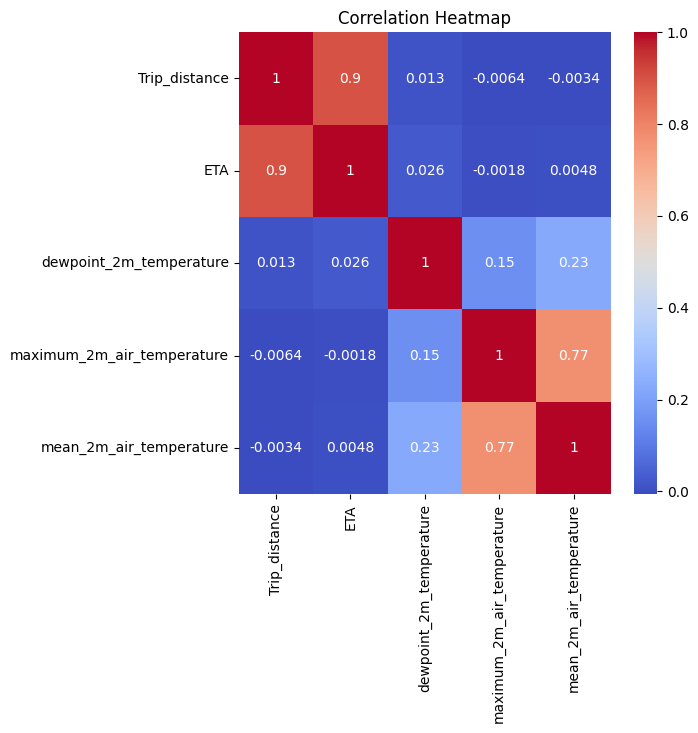

In [21]:
# Correlation Heatmap
correlation_matrix = df_train[['Trip_distance', 'ETA', 'dewpoint_2m_temperature',
                         'maximum_2m_air_temperature', 'mean_2m_air_temperature']].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Is the train data complete?

In [29]:
get_missing_dates(df_train)

we have 0 dates missing out of 83766
start: 2019-11-19, end: 2019-12-19


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [30]:
get_missing_dates(df_test)

we have 0 dates missing out of 35545
start: 2019-12-20, end: 2019-12-31


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [31]:
# missing values imputation
train = fill_missing_dates(df_train)
test = fill_missing_dates(df_test)

Do we have seasonality in ETA?

In [32]:
#time series data is stored in the variable 'eta_data'
eta_data = df_train['ETA']

In [36]:
# Perform KPSS test
kpss_result = kpss(eta_data)
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_critical_values = kpss_result[3]

In [37]:
print("\nKPSS Test:")
print("KPSS Statistic:", kpss_statistic)
print("p-value:", kpss_pvalue)


KPSS Test:
KPSS Statistic: 0.6261575351853694
p-value: 0.02025840589223914


stationary if p-value > 0.05

series is stationary since 0.02 < 0.05

In [39]:
# Perform the ADF test
result = adfuller(df_train['ETA'])

# Extract and print the results
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Check the p-value against a significance level (e.g., 0.05) to make a decision about stationarity
if p_value <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -31.05057817565558
p-value: 0.0
The time series is likely stationary.


What is the distribution of ETA?

In [40]:
# Distribution of ETA:
print("Mean ETA:", df_train['ETA'].mean())
print("Median ETA:", df_train['ETA'].median())
print("Standard Deviation of ETA:", df_train['ETA'].std())

Mean ETA: 1111.9316429100113
Median ETA: 1054.0
Standard Deviation of ETA: 563.6417384674885


What is the distribution of trip distances?

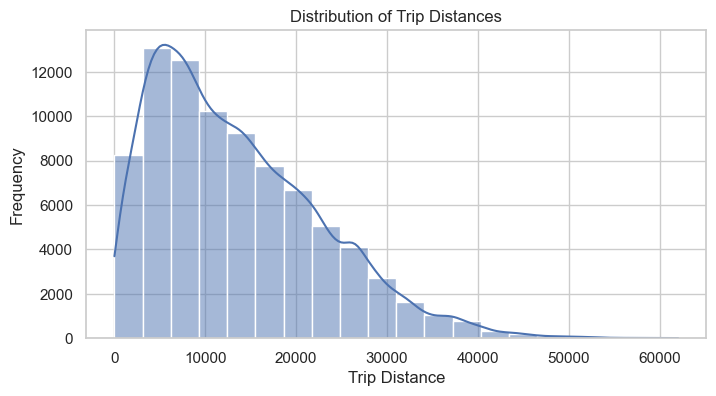

In [45]:
# Set seaborn style
sns.set(style="whitegrid")

# Question 1: Distribution of Trip Distances
plt.figure(figsize=(8, 4))
sns.histplot(df_train['Trip_distance'], bins=20, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.show()

How does ETA vary over time? Is there a trend?

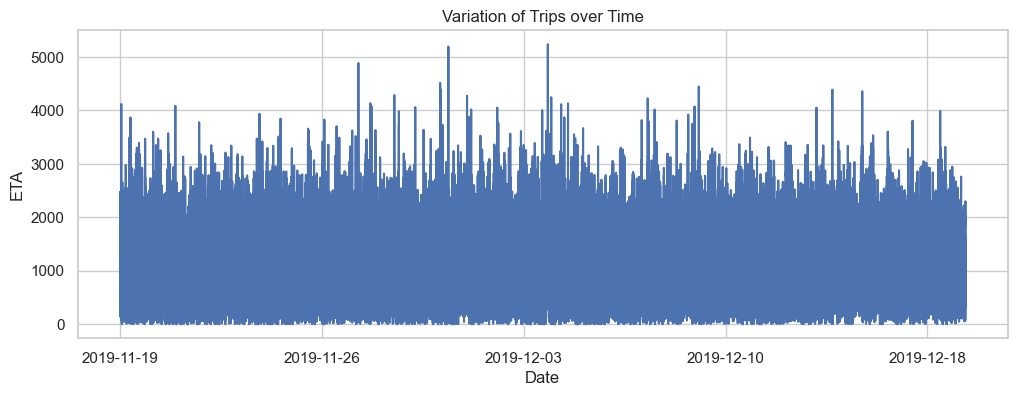

In [47]:
# Question 2: Variation of Trips over Time
plt.figure(figsize=(12, 4))
df_train['ETA'].plot()
plt.title('Variation of Trips over Time')
plt.xlabel('Date')
plt.ylabel('ETA')
plt.show()

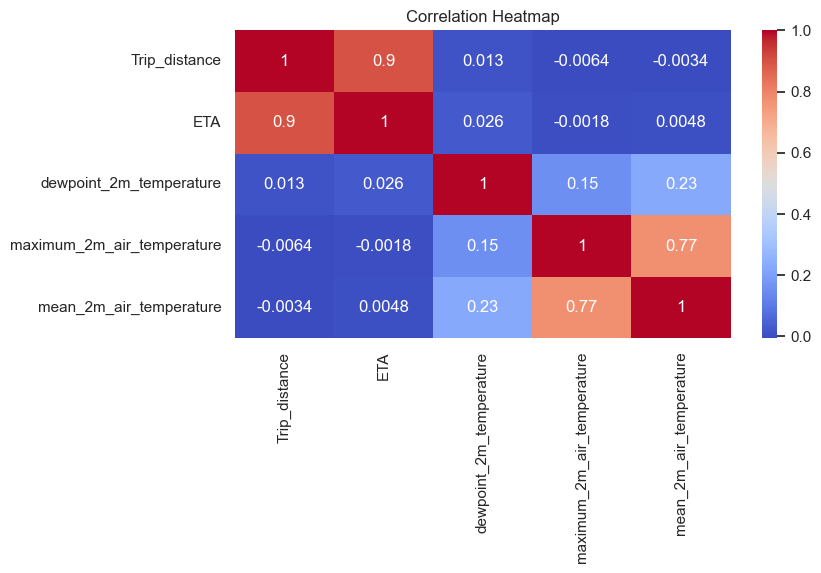

In [49]:
# Question 3: Correlation Heatmap
correlation_matrix = df_train[['Trip_distance', 'ETA', 'dewpoint_2m_temperature',
                         'maximum_2m_air_temperature', 'mean_2m_air_temperature']].corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

maximum_2m_air_temperature and mean_2m_air_temperature have a high correlation of 0.77 or 77%

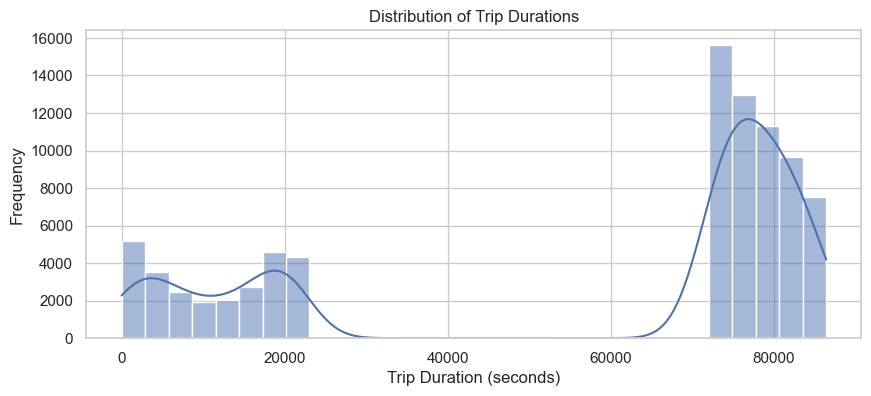

In [50]:
# Question 4: Distribution of Trip Durations
plt.figure(figsize=(10, 4))
sns.histplot(df_train['total_secs'], bins=30, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

### Features Encoding & scaling

In [51]:
numeric_columns = df_train.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
numeric_columns

['Origin_lat',
 'Origin_lon',
 'Destination_lat',
 'Destination_lon',
 'Trip_distance',
 'ETA',
 'total_secs',
 'dewpoint_2m_temperature',
 'maximum_2m_air_temperature',
 'mean_2m_air_temperature',
 'mean_sea_level_pressure',
 'minimum_2m_air_temperature',
 'surface_pressure',
 'total_precipitation',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m']

In [52]:
categoric_columns = [col for col in df_train.columns if col not in numeric_columns]
categoric_columns

[]

In [53]:
numeric_columns.remove('ETA')

#### Scaling

In [57]:
# Create an instance of StandardScaler and set output to be a DataFrame
scaler = StandardScaler().fit(df_train[numeric_columns]).set_output(transform="pandas")

num = scaler.transform(df_train[numeric_columns])
num_test = scaler.transform(df_test[numeric_columns])

In [59]:
num.sample(2)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,total_secs,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
date,,,,,,,,,,,,,,,
2019-12-10,-0.398663,0.425343,0.258623,-0.998504,-0.324641,0.927455,-0.774680,-1.319035,-1.161882,1.682382,-1.441260,1.670546,0.009754,0.192992,-2.020913
2019-12-09,0.483206,-2.224596,-0.436416,1.350406,0.676479,0.526555,0.715378,-0.628966,-0.359522,1.590260,-0.243236,1.584530,-0.310731,1.064820,-0.266482


#### Splitting

In [60]:
cut_num = len(df_train) * 0.12
cut_num = int(cut_num)

In [61]:
df_train, eval_set = df_train[cut_num:], df_train[:cut_num]

In [62]:
# Split data into parts
x = df_train.drop(['ETA'], axis = 1)
y = df_train['ETA']

In [63]:
cut_num = len(train) * 0.2
cut_num = int(cut_num)

In [64]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[cut_num:], x[:cut_num], y[cut_num:], y[:cut_num]

### ML Model Building

#### RandomForest Regressor

In [66]:
randforest = RandomForestRegressor()
rfModel = randforest.fit(X_train, y_train)

In [67]:
rfModel_pred = rfModel.predict(X_test)

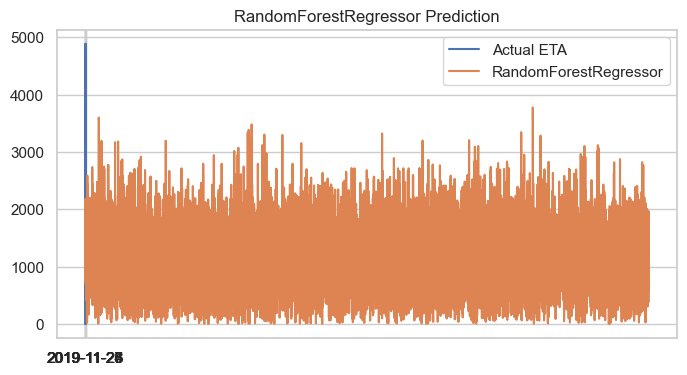

In [69]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual ETA')
plt.plot(rfModel_pred, label='RandomForestRegressor')
plt.legend(loc='best')
plt.title('RandomForestRegressor Prediction')
plt.show()

In [72]:
mse = mean_squared_error(y_test, rfModel_pred)
msle = mean_squared_log_error(y_test, rfModel_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Append the results to the DataFrame
results = pd.DataFrame([['Random Forest', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,34091.571022,0.035977,184.64,0.18968


### XG Boost

In [74]:
# Initialize and fit the XGBoost model
xgboost = xgb.XGBRegressor()
xgbModel = xgboost.fit(X_train, y_train)

# Make predictions on X_test
xgbModel_pred = xgbModel.predict(X_test)


In [75]:
# Append the results to the DataFrame
mse = mean_squared_error(y_test, xgbModel_pred)
# msle = mean_squared_log_error(y_test, xgbModel_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['XGBoost', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)
results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,34091.571022,0.035977,184.64,0.18968
1,XGBoost,26571.624549,0.035977,163.01,0.18968


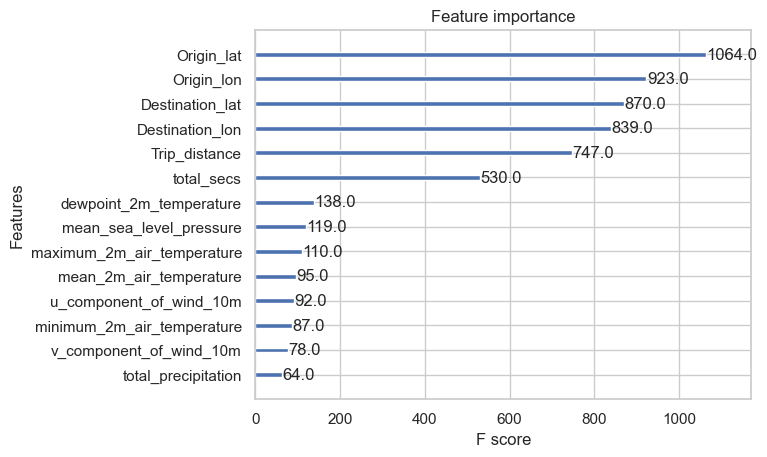

Origin_lat: 1064.0
Origin_lon: 923.0
Destination_lat: 870.0
Destination_lon: 839.0
Trip_distance: 747.0
total_secs: 530.0
dewpoint_2m_temperature: 138.0
mean_sea_level_pressure: 119.0
maximum_2m_air_temperature: 110.0
mean_2m_air_temperature: 95.0
u_component_of_wind_10m: 92.0
minimum_2m_air_temperature: 87.0
v_component_of_wind_10m: 78.0
total_precipitation: 64.0


In [76]:
# Using plot_importance function to visualize feature importance
xgb.plot_importance(xgbModel)
plt.show()

# Alternatively, you can use the get_booster() method to get the booster object
booster = xgbModel.get_booster()

# Get the feature importance scores
importance_scores = booster.get_score(importance_type='weight')

# Sort the importance scores in descending order
sorted_importance_scores = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# Print the sorted importance scores
for feature, score in sorted_importance_scores:
    print(f"{feature}: {score}")

### Model Evaluation

In [79]:
# Split data into parts
x_eval = eval_set.drop(['ETA'], axis = 1)
y_eval = eval_set['ETA']

In [80]:
xgboost_pred_eval = xgbModel.predict(x_eval)
mse = mean_squared_error(y_eval, xgboost_pred_eval)
rmse = np.sqrt(mse).round(2)
rmse

148.48

Generate pickle file

In [83]:
with open('../scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('../model.pkl', 'wb') as f:
    pickle.dump(xgbModel, f)